In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utilsF import Fmnist, plot_graphs
import numpy as np

In [2]:
train_loader, valid_loader, test_loader = Fmnist(valid=40000)

In [13]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 784)
        self.fc2 = nn.Linear(784, 512)
        self.fc3 = nn.Linear(512, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(784)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [18]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
    
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, train_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)
    
    train_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in train_loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                train_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        train_loss[k] /= train_size
    correct_pct = {k: 100. * correct[k] / train_size for k in correct}
    lines = '\n'.join([line(k, train_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Train set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((train_loss[k], correct_pct[k]))
    print(report)

In [19]:
models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [20]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [28]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/20000 (0%)]	Losses default: 0.174312 bn: 0.125695 drop: 0.185760 both: 0.160666
Train Epoch: 1 [10000/20000 (50%)]	Losses default: 0.206431 bn: 0.191045 drop: 0.213600 both: 0.211448
Train Epoch: 1 [20000/20000 (100%)]	Losses default: 0.247039 bn: 0.232521 drop: 0.259501 both: 0.313457
Train set:
default: Loss: 0.2337	Accuracy: 18354.0/20000 (92%)
bn: Loss: 0.1925	Accuracy: 18619.0/20000 (93%)
drop: Loss: 0.2753	Accuracy: 18037.0/20000 (90%)
both: Loss: 0.2271	Accuracy: 18378.0/20000 (92%)

Test set:
default: Loss: 0.3437	Accuracy: 35062.0/40000 (88%)
bn: Loss: 0.3407	Accuracy: 35057.0/40000 (88%)
drop: Loss: 0.3715	Accuracy: 34711.0/40000 (87%)
both: Loss: 0.3517	Accuracy: 35008.0/40000 (88%)

Train Epoch: 2 [0/20000 (0%)]	Losses default: 0.452913 bn: 0.316262 drop: 0.545620 both: 0.376514
Train Epoch: 2 [10000/20000 (50%)]	Losses default: 0.184975 bn: 0.227488 drop: 0.269630 both: 0.253753
Train Epoch: 2 [20000/20000 (100%)]	Losses default: 0.209910 bn: 0.179363 dro

Train set:
default: Loss: 0.1374	Accuracy: 19052.0/20000 (95%)
bn: Loss: 0.0892	Accuracy: 19403.0/20000 (97%)
drop: Loss: 0.1864	Accuracy: 18664.0/20000 (93%)
both: Loss: 0.1146	Accuracy: 19222.0/20000 (96%)

Test set:
default: Loss: 0.3467	Accuracy: 35337.0/40000 (88%)
bn: Loss: 0.3871	Accuracy: 35229.0/40000 (88%)
drop: Loss: 0.3619	Accuracy: 35017.0/40000 (88%)
both: Loss: 0.3785	Accuracy: 35186.0/40000 (88%)

Train Epoch: 13 [0/20000 (0%)]	Losses default: 0.227355 bn: 0.132775 drop: 0.286291 both: 0.149702
Train Epoch: 13 [10000/20000 (50%)]	Losses default: 0.148403 bn: 0.112387 drop: 0.187276 both: 0.171748
Train Epoch: 13 [20000/20000 (100%)]	Losses default: 0.111839 bn: 0.050911 drop: 0.090695 both: 0.050026
Train set:
default: Loss: 0.1343	Accuracy: 19109.0/20000 (96%)
bn: Loss: 0.0804	Accuracy: 19446.0/20000 (97%)
drop: Loss: 0.1908	Accuracy: 18624.0/20000 (93%)
both: Loss: 0.1028	Accuracy: 19271.0/20000 (96%)

Test set:
default: Loss: 0.3607	Accuracy: 35189.0/40000 (88%)
bn: 

Train Epoch: 24 [10000/20000 (50%)]	Losses default: 0.116908 bn: 0.092219 drop: 0.136203 both: 0.129443
Train Epoch: 24 [20000/20000 (100%)]	Losses default: 0.100535 bn: 0.072513 drop: 0.104820 both: 0.055149
Train set:
default: Loss: 0.1346	Accuracy: 18922.0/20000 (95%)
bn: Loss: 0.0516	Accuracy: 19653.0/20000 (98%)
drop: Loss: 0.1418	Accuracy: 18930.0/20000 (95%)
both: Loss: 0.0745	Accuracy: 19483.0/20000 (97%)

Test set:
default: Loss: 0.4738	Accuracy: 34583.0/40000 (86%)
bn: Loss: 0.4756	Accuracy: 35137.0/40000 (88%)
drop: Loss: 0.4237	Accuracy: 34754.0/40000 (87%)
both: Loss: 0.4647	Accuracy: 35125.0/40000 (88%)

Train Epoch: 25 [0/20000 (0%)]	Losses default: 0.159461 bn: 0.061633 drop: 0.216737 both: 0.049781
Train Epoch: 25 [10000/20000 (50%)]	Losses default: 0.117753 bn: 0.021064 drop: 0.122502 both: 0.065513
Train Epoch: 25 [20000/20000 (100%)]	Losses default: 0.170418 bn: 0.181226 drop: 0.273082 both: 0.067092
Train set:
default: Loss: 0.0888	Accuracy: 19411.0/20000 (97%)
bn:

Test set:
default: Loss: 0.4705	Accuracy: 35246.0/40000 (88%)
bn: Loss: 0.5668	Accuracy: 35035.0/40000 (88%)
drop: Loss: 0.4430	Accuracy: 35124.0/40000 (88%)
both: Loss: 0.5291	Accuracy: 35258.0/40000 (88%)

Train Epoch: 36 [0/20000 (0%)]	Losses default: 0.012695 bn: 0.014189 drop: 0.033136 both: 0.014963
Train Epoch: 36 [10000/20000 (50%)]	Losses default: 0.022432 bn: 0.021526 drop: 0.024497 both: 0.025916
Train Epoch: 36 [20000/20000 (100%)]	Losses default: 0.178723 bn: 0.078546 drop: 0.243031 both: 0.239531
Train set:
default: Loss: 0.0364	Accuracy: 19771.0/20000 (99%)
bn: Loss: 0.0338	Accuracy: 19773.0/20000 (99%)
drop: Loss: 0.0612	Accuracy: 19587.0/20000 (98%)
both: Loss: 0.0432	Accuracy: 19711.0/20000 (99%)

Test set:
default: Loss: 0.4889	Accuracy: 35209.0/40000 (88%)
bn: Loss: 0.5763	Accuracy: 35183.0/40000 (88%)
drop: Loss: 0.4593	Accuracy: 35100.0/40000 (88%)
both: Loss: 0.5488	Accuracy: 35169.0/40000 (88%)

Train Epoch: 37 [0/20000 (0%)]	Losses default: 0.033347 bn: 0.00542

Train Epoch: 47 [10000/20000 (50%)]	Losses default: 0.196017 bn: 0.210291 drop: 0.240832 both: 0.061747
Train Epoch: 47 [20000/20000 (100%)]	Losses default: 0.027600 bn: 0.016501 drop: 0.017572 both: 0.006920
Train set:
default: Loss: 0.0291	Accuracy: 19812.0/20000 (99%)
bn: Loss: 0.0236	Accuracy: 19829.0/20000 (99%)
drop: Loss: 0.0494	Accuracy: 19646.0/20000 (98%)
both: Loss: 0.0382	Accuracy: 19714.0/20000 (99%)

Test set:
default: Loss: 0.5789	Accuracy: 35207.0/40000 (88%)
bn: Loss: 0.6169	Accuracy: 35187.0/40000 (88%)
drop: Loss: 0.5382	Accuracy: 35141.0/40000 (88%)
both: Loss: 0.6036	Accuracy: 35147.0/40000 (88%)

Train Epoch: 48 [0/20000 (0%)]	Losses default: 0.002624 bn: 0.028207 drop: 0.004096 both: 0.040060
Train Epoch: 48 [10000/20000 (50%)]	Losses default: 0.026473 bn: 0.002120 drop: 0.028153 both: 0.004571
Train Epoch: 48 [20000/20000 (100%)]	Losses default: 0.036604 bn: 0.019977 drop: 0.103120 both: 0.068707
Train set:
default: Loss: 0.0410	Accuracy: 19708.0/20000 (99%)
bn:

Test set:
default: Loss: 0.6376	Accuracy: 35219.0/40000 (88%)
bn: Loss: 0.6737	Accuracy: 35225.0/40000 (88%)
drop: Loss: 0.5660	Accuracy: 35311.0/40000 (88%)
both: Loss: 0.6471	Accuracy: 35150.0/40000 (88%)

Train Epoch: 59 [0/20000 (0%)]	Losses default: 0.012131 bn: 0.045020 drop: 0.014290 both: 0.001265
Train Epoch: 59 [10000/20000 (50%)]	Losses default: 0.007612 bn: 0.052776 drop: 0.044638 both: 0.008038
Train Epoch: 59 [20000/20000 (100%)]	Losses default: 0.008353 bn: 0.058745 drop: 0.022518 both: 0.063444
Train set:
default: Loss: 0.0264	Accuracy: 19821.0/20000 (99%)
bn: Loss: 0.0117	Accuracy: 19927.0/20000 (100%)
drop: Loss: 0.0392	Accuracy: 19728.0/20000 (99%)
both: Loss: 0.0282	Accuracy: 19799.0/20000 (99%)

Test set:
default: Loss: 0.6517	Accuracy: 35023.0/40000 (88%)
bn: Loss: 0.6664	Accuracy: 35328.0/40000 (88%)
drop: Loss: 0.6119	Accuracy: 34905.0/40000 (87%)
both: Loss: 0.6733	Accuracy: 35215.0/40000 (88%)

Train Epoch: 60 [0/20000 (0%)]	Losses default: 0.017354 bn: 0.0014

Train Epoch: 70 [10000/20000 (50%)]	Losses default: 0.029247 bn: 0.001895 drop: 0.004903 both: 0.005764
Train Epoch: 70 [20000/20000 (100%)]	Losses default: 0.001297 bn: 0.004626 drop: 0.019839 both: 0.003145
Train set:
default: Loss: 0.0055	Accuracy: 19978.0/20000 (100%)
bn: Loss: 0.0114	Accuracy: 19924.0/20000 (100%)
drop: Loss: 0.0520	Accuracy: 19639.0/20000 (98%)
both: Loss: 0.0164	Accuracy: 19894.0/20000 (99%)

Test set:
default: Loss: 0.6599	Accuracy: 35279.0/40000 (88%)
bn: Loss: 0.6796	Accuracy: 35166.0/40000 (88%)
drop: Loss: 0.7011	Accuracy: 34691.0/40000 (87%)
both: Loss: 0.6975	Accuracy: 35211.0/40000 (88%)

Train Epoch: 71 [0/20000 (0%)]	Losses default: 0.001456 bn: 0.059144 drop: 0.029426 both: 0.009010
Train Epoch: 71 [10000/20000 (50%)]	Losses default: 0.008663 bn: 0.007588 drop: 0.022410 both: 0.114621
Train Epoch: 71 [20000/20000 (100%)]	Losses default: 0.001563 bn: 0.027044 drop: 0.008321 both: 0.003250
Train set:
default: Loss: 0.0058	Accuracy: 19976.0/20000 (100%)


Train set:
default: Loss: 0.0014	Accuracy: 19997.0/20000 (100%)
bn: Loss: 0.0140	Accuracy: 19908.0/20000 (100%)
drop: Loss: 0.0190	Accuracy: 19868.0/20000 (99%)
both: Loss: 0.0226	Accuracy: 19847.0/20000 (99%)

Test set:
default: Loss: 0.6884	Accuracy: 35361.0/40000 (88%)
bn: Loss: 0.7441	Accuracy: 35190.0/40000 (88%)
drop: Loss: 0.7064	Accuracy: 35024.0/40000 (88%)
both: Loss: 0.7625	Accuracy: 35087.0/40000 (88%)

Train Epoch: 82 [0/20000 (0%)]	Losses default: 0.000919 bn: 0.000388 drop: 0.006812 both: 0.001346
Train Epoch: 82 [10000/20000 (50%)]	Losses default: 0.002275 bn: 0.006277 drop: 0.020715 both: 0.008148
Train Epoch: 82 [20000/20000 (100%)]	Losses default: 0.055184 bn: 0.002237 drop: 0.041002 both: 0.038004
Train set:
default: Loss: 0.0174	Accuracy: 19874.0/20000 (99%)
bn: Loss: 0.0258	Accuracy: 19819.0/20000 (99%)
drop: Loss: 0.0225	Accuracy: 19853.0/20000 (99%)
both: Loss: 0.0197	Accuracy: 19862.0/20000 (99%)

Test set:
default: Loss: 0.7005	Accuracy: 35156.0/40000 (88%)
bn

Test set:
default: Loss: 0.7004	Accuracy: 35357.0/40000 (88%)
bn: Loss: 0.7569	Accuracy: 35250.0/40000 (88%)
drop: Loss: 0.7383	Accuracy: 35044.0/40000 (88%)
both: Loss: 0.7665	Accuracy: 35277.0/40000 (88%)

Train Epoch: 93 [0/20000 (0%)]	Losses default: 0.003888 bn: 0.009707 drop: 0.076111 both: 0.033421
Train Epoch: 93 [10000/20000 (50%)]	Losses default: 0.000536 bn: 0.002933 drop: 0.000800 both: 0.001498
Train Epoch: 93 [20000/20000 (100%)]	Losses default: 0.000702 bn: 0.006565 drop: 0.009949 both: 0.001915
Train set:
default: Loss: 0.0034	Accuracy: 19982.0/20000 (100%)
bn: Loss: 0.0169	Accuracy: 19882.0/20000 (99%)
drop: Loss: 0.0138	Accuracy: 19912.0/20000 (100%)
both: Loss: 0.0128	Accuracy: 19919.0/20000 (100%)

Test set:
default: Loss: 0.7084	Accuracy: 35314.0/40000 (88%)
bn: Loss: 0.7418	Accuracy: 35177.0/40000 (88%)
drop: Loss: 0.7232	Accuracy: 35202.0/40000 (88%)
both: Loss: 0.7381	Accuracy: 35241.0/40000 (88%)

Train Epoch: 94 [0/20000 (0%)]	Losses default: 0.000752 bn: 0.00

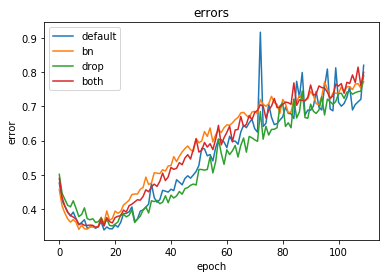

In [29]:
plot_graphs(test_log, 'loss')

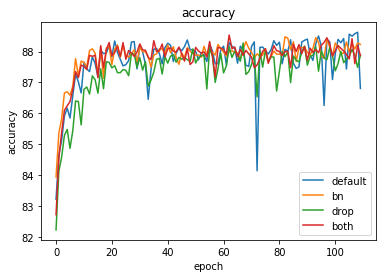

In [30]:
plot_graphs(test_log, 'accuracy')

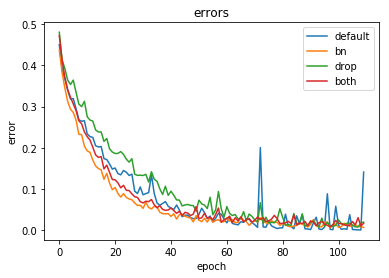

In [31]:
plot_graphs(train_log, 'loss')

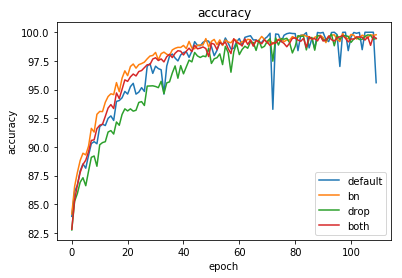

In [32]:
plot_graphs(train_log, 'accuracy')

In [23]:
test_log

{'default': [(0.4760048330307007, 83.23),
  (0.4234922003746033, 84.66),
  (0.40791028941869734, 85.1325),
  (0.39093758747577667, 85.9225),
  (0.37938363164663313, 86.17),
  (0.39068106770515443, 85.855),
  (0.37092602189779283, 86.5775),
  (0.3530512134194374, 87.2725),
  (0.36027425192594525, 87.02),
  (0.368325309419632, 86.6625)],
 'bn': [(0.4565416304588318, 83.95),
  (0.4085029195666313, 85.36),
  (0.3873803412437439, 85.8325),
  (0.37095033984184267, 86.6625),
  (0.36124486131668093, 86.7),
  (0.36872400511503217, 86.5875),
  (0.3604732627511025, 86.8825),
  (0.34006029789447784, 87.7725),
  (0.35249849548339846, 87.2125),
  (0.341930808866024, 87.6925)],
 'drop': [(0.501035135769844, 82.24),
  (0.445496479344368, 84.135),
  (0.4278850686788559, 84.59),
  (0.41067483596801757, 85.29),
  (0.40590943826437, 85.485),
  (0.4235714433193207, 84.8725),
  (0.40159445761442186, 85.445),
  (0.37753746151924134, 86.4025),
  (0.3835021538972855, 86.385),
  (0.40306214628219605, 85.6325)],

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from matplotlib.backends.backend_pdf import PdfPages

def draw(X, Y):
  fig1 = plt.figure()
  plot_graphs(X, 'loss')
  fig2= plt.figure()
  plot_graphs(Y, 'loss')
  pp = PdfPages("pereobuchenie.pdf")
  pp.savefig(fig1, dpi = 300, transparent = True)
  pp.savefig(fig2, dpi = 300, transparent = True)
  pp.close() 

In [ ]:
draw(train_log, test_log)